In [39]:
from nd2_combine import tools
from segment import seg
from droplet_growth import multiwell
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import logging
import os
import math
import pandas as pd
import re
from skimage.morphology import convex_hull_image
from skimage.transform import rotate
from scipy.ndimage import gaussian_filter1d as gf
from scipy.interpolate import interp1d
import seaborn as sns
import json
import re
logging.basicConfig(level=logging.DEBUG)

logger = logging.getLogger()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
def segment_bf(well, thr=0.5, smooth=10, erode=10, fill=True, plot=False):
    '''
    Serments input 2d array using thresholded gradient with filling
    Returns SegmentedImage object
    '''
    grad = multiwell.get_2d_gradient(well)
    sm = multiwell.gaussian_filter(grad, smooth)
#     sm = multiwell.gaussian_filter(well, smooth)
    
    regions = sm > thr * sm.max()
    
    if fill:
        regions = multiwell.binary_fill_holes(regions)
    
    if erode:
        regions = multiwell.binary_erosion(regions, iterations=erode)
    
    labels, n_labels = multiwell.label(regions)
    print(f'{n_labels} regions')
    if plot:
        fig, ax = multiwell.plt.subplots(1,2)
        ax[0].imshow(well, cmap='gray')
        ax[1].imshow(labels)
        plt.show()
        
    return labels


def crop_center(array):
    shape = array.shape
    crop =  array[
        shape[0] // 4 : shape[0] * 3 // 4, shape[1] // 4 : shape[1] * 3 // 4,
    ]
    return crop

In [131]:
from pims_nd2 import ND2_Reader as nd
# from nd2reader import ND2Reader as nd

def read_nd2(path:str, bundle_axes='cyx', pos_limit=None, well_index=None):
    logger.debug(f'read_nd2: open {path}')
    with nd(path,) as frames:
        print(frames.sizes)
#         channels = [
#             frames.metadata[f'plane_{i}']['name'] for i in range(
#                 frames.sizes['c']
#             )
#         ]
#         print(channels)
        px_size_um = frames.calibration
        frames.iter_axes = 'm'
        frames.bundle_axes = bundle_axes
        for f in frames:
            print(f.metadata)
            yield {'path': '/'.join(path.split('/')[-3:]), 'stack': f, 'pixel_size_um': px_size_um, 'well': f.metadata['coords']['m']}
            

def process_2_colors(stack=None, path='', pixel_size_um=1., min_size=25, bins=20, staining=['TRITC', 'FITC'], plot=True, crop=True, **kwargs):
    
    bf, fitc, tritc = stack[:3]
    
    if crop:
        bf = crop_center(bf)
        bf = crop_center(bf)
        fitc = crop_center(fitc)
        tritc = crop_center(tritc)
        fitc = crop_center(fitc)
        tritc = crop_center(tritc)
    print('fitc')
    labels = segment_bf(bf, thr=.5, plot=plot)
    props = multiwell.regionprops(labels)
    filtered_props = list(filter(lambda p: p.major_axis_length > min_size, props))
    print(f'{len(filtered_props)} regions after filtering using min size {min_size}')
    
    datas = []
    for ind, prop in enumerate(filtered_props):
        mask = labels == prop.label
        good_mask = convex_hull_image(mask).astype(int)
        if plot:
            plt.imshow(good_mask)
            plt.title('Convex area')
            plt.show()
        
        I_tritc = multiwell.regionprops(good_mask, intensity_image=tritc)[0].mean_intensity
        I_fitc = multiwell.regionprops(good_mask, intensity_image=fitc)[0].mean_intensity
        
        convex_prop = multiwell.regionprops(good_mask)[0]
        
        data = {'path': path, 
                'size_um': prop.major_axis_length * pixel_size_um,
                'area': prop.area * pixel_size_um ** 2,
                'perimeter': prop.perimeter * pixel_size_um,
                'circularity': prop.area / (prop.perimeter ** 2) * 4 * np.pi,
                'convex_area': convex_prop.area * pixel_size_um ** 2,
                'convex_eccentricity': convex_prop.eccentricity * pixel_size_um,
                'convex_perimeter': convex_prop.perimeter * pixel_size_um,
                'convex_circularity': convex_prop.area / (convex_prop.perimeter ** 2) * 4 * np.pi,
                'convex_eccentricity': convex_prop.eccentricity * pixel_size_um,
                'tritc': I_tritc,
                'fitc': I_fitc,
                'index': ind, 
                **kwargs
        }
        datas.append(data)
    df = pd.DataFrame(datas)
    return df

In [132]:
fluo_path = r'/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/To_analyze/*/*/*.nd2'
flist = glob(fluo_path)
flist

['/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/To_analyze/24092020/12uL/Chip_3.nd2',
 '/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/To_analyze/24092020/12uL/Chip_4.nd2',
 '/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/To_analyze/24092020/12uL/Chip_2.nd2',
 '/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/To_analyze/24092020/12uL/Chip_1.nd2',
 '/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/To_analyze/04092020/12uL/Chip_1000.nd2',
 '/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/To_analyze/04092020/12uL/Chip_700.nd2',
 '/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/To_analyze/26082020/12uL/Chip_2.nd2',
 '/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/To_analyze/26082020/12uL/Chip_1.nd2',
 '/home/aaristov/Mu

In [133]:
results = pd.DataFrame()
for f in flist[:]:
    print(f)
    reader = read_nd2(f)
    for well in reader:
        result = process_2_colors(**well, plot=False, min_size=50)
        results = pd.concat((results, result))


/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/To_analyze/24092020/12uL/Chip_3.nd2
{'x': 2048, 'y': 2044, 'c': 3, 'm': 66}
{'x_um': -27179.4, 'y_um': 12786.1, 'z_um': 4909.225, 't_ms': 2713.110898733139, 'colors': [(1.0, 1.0, 1.0), (0.0, 1.0, 0.0), (1.0, 0.0, 0.0)], 'mpp': 1.625, 'max_value': 65535, 'x': 0, 'y': 0, 'c': array([0, 1, 2]), 'm': 0, 'axes': ['c', 'y', 'x'], 'coords': {'m': 0}}
fitc
2 regions
1 regions after filtering using min size 50
{'x_um': -19221.2, 'y_um': 12786.1, 'z_um': 4909.225, 't_ms': 5669.882871389389, 'colors': [(1.0, 1.0, 1.0), (0.0, 1.0, 0.0), (1.0, 0.0, 0.0)], 'mpp': 1.625, 'max_value': 65535, 'x': 0, 'y': 0, 'c': array([0, 1, 2]), 'm': 1, 'axes': ['c', 'y', 'x'], 'coords': {'m': 1}}
fitc
1 regions
0 regions after filtering using min size 50
{'x_um': -11366.0, 'y_um': 12786.1, 'z_um': 4909.225, 't_ms': 8659.505918264389, 'colors': [(1.0, 1.0, 1.0), (0.0, 1.0, 0.0), (1.0, 0.0, 0.0)], 'mpp': 1.625, 'max_value': 65535, 'x': 0

/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/pims/base_frames.py:472: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


{'x_um': -3568.3, 'y_um': 12698.300000000001, 'z_um': 4909.225, 't_ms': 11020.539853811264, 'colors': [(1.0, 1.0, 1.0), (0.0, 1.0, 0.0), (1.0, 0.0, 0.0)], 'mpp': 1.625, 'max_value': 65535, 'x': 0, 'y': 0, 'c': array([0, 1, 2]), 'm': 3, 'axes': ['c', 'y', 'x'], 'coords': {'m': 3}}
fitc
1 regions
0 regions after filtering using min size 50
{'x_um': 12606.300000000001, 'y_um': 12038.900000000001, 'z_um': 4909.225, 't_ms': 13384.672910451889, 'colors': [(1.0, 1.0, 1.0), (0.0, 1.0, 0.0), (1.0, 0.0, 0.0)], 'mpp': 1.625, 'max_value': 65535, 'x': 0, 'y': 0, 'c': array([0, 1, 2]), 'm': 4, 'axes': ['c', 'y', 'x'], 'coords': {'m': 4}}
fitc
1 regions
0 regions after filtering using min size 50
{'x_um': 16370.6, 'y_um': 9277.800000000001, 'z_um': 4909.225, 't_ms': 16178.905820608139, 'colors': [(1.0, 1.0, 1.0), (0.0, 1.0, 0.0), (1.0, 0.0, 0.0)], 'mpp': 1.625, 'max_value': 65535, 'x': 0, 'y': 0, 'c': array([0, 1, 2]), 'm': 5, 'axes': ['c', 'y', 'x'], 'coords': {'m': 5}}
fitc
1 regions
1 regions afte

In [134]:
results

path     size_um          area    perimeter  \
0   24092020/12uL/Chip_3.nd2  119.716246   7245.875000   358.790151   
0   24092020/12uL/Chip_3.nd2   85.651427   3158.187500   224.385299   
0   24092020/12uL/Chip_3.nd2   83.096603   4475.859375   263.452949   
0   24092020/12uL/Chip_3.nd2   82.626312   4261.968750   254.818173   
0   24092020/12uL/Chip_3.nd2  142.300151   8708.781250   387.414890   
..                       ...         ...           ...          ...   
0   18092020/12uL/Chip_1.nd2  157.831823  18560.953125   543.319219   
0   18092020/12uL/Chip_1.nd2  267.351738  29820.578125   836.551758   
0   18092020/12uL/Chip_1.nd2  257.460838   9091.671875   640.781290   
0   18092020/12uL/Chip_1.nd2  936.791505  29421.843750  1789.522691   
0   18092020/12uL/Chip_1.nd2  414.008415  13982.109375   916.429242   

    circularity   convex_area  convex_eccentricity  convex_perimeter  \
0      0.707326   8040.703125             1.178842        358.790151   
0      0.788241   3240.046875             1.337830        224.385299   
0      0.810364   4710.875000             0.889001        263.452949   
0      0.824820   4460.015625             0.862863        254.818173   
0      0.729146   9062.625000             1.333553        387.414890   
..          ...           ...                  ...               ...   
0      0.790133  19809.968750             0.593685        537.213510   
0      0.535476  34370.375000             1.367937        784.089817   
0      0.278249  15701.156250             1.550210        623.127354   
0      0.115453  69448.437500             1.609526       1769.329780   
0      0.209211  18642.812500             1.605463        922.313888   

    convex_circularity       tritc        fitc  index  well  
0             0.784915  135.300493  484.284729      0     0  
0             0.808672  133.409128  464.078240      0     5  
0             0.852914  136.314462  560.348655      0    10  
0             0.863148  135.027235  469.208999      0    11  
0             0.758772  133.686772  584.959207      0    13  
..                 ...         ...         ...    ...   ...  
0             0.862581  131.109171  376.492402      0    51  
0             0.702526  135.378073  579.289336      0    52  
0             0.508145  133.945846  252.126976      0    53  
0             0.278776  131.154677  130.513042      0    54  
0             0.275400  120.735127  130.129887      0    55  

[536 rows x 13 columns]

In [135]:
data = results.query('size_um < 300')

Text(0.5, 0, 'size_um')

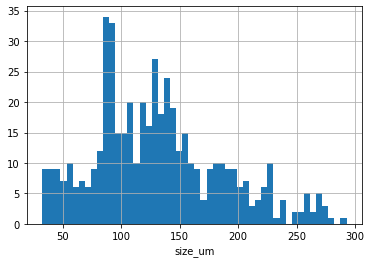

In [136]:
data.size_um.hist(bins=50)
plt.xlabel('size_um')

In [161]:
data.size_um.mean()

130.83945660001314

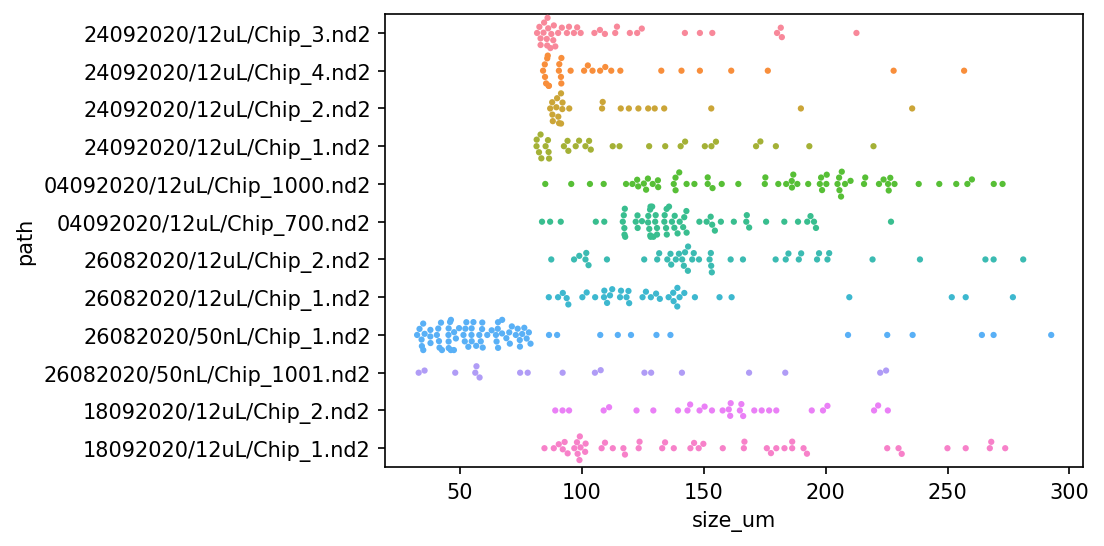

In [162]:
fig, ax = plt.subplots(dpi=150)
sns.swarmplot(y='path', x='size_um', data=data, size=3)


In [152]:
data['mean_size'] = list(map(lambda path: data[data.path == path].size_um.mean(), data.path))

<ipython-input-152-c32a00b9f5a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mean_size'] = list(map(lambda path: data[data.path == path].size_um.mean(), data.path))


In [153]:
data['med_size'] = list(map(lambda path: data[data.path == path].size_um.median(), data.path))

<ipython-input-153-84108a0c02f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['med_size'] = list(map(lambda path: data[data.path == path].size_um.median(), data.path))


In [154]:
data['norm_size'] = data.size_um / data.mean_size

<ipython-input-154-efc6ea8d7166>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['norm_size'] = data.size_um / data.mean_size


In [155]:
data['normd_size'] = data.size_um / data.med_size

<ipython-input-155-adc641bd0f12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['normd_size'] = data.size_um / data.med_size


Text(0.5, 0, 'size normalized by mean per chip')

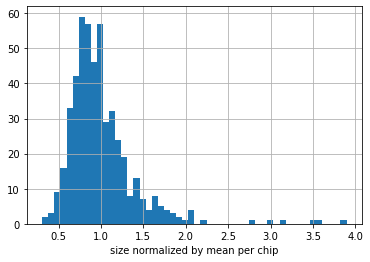

In [156]:
data.norm_size.hist(bins=50)
plt.xlabel('size normalized by mean per chip')

Text(0.5, 0, 'size normalized by median size per chip')

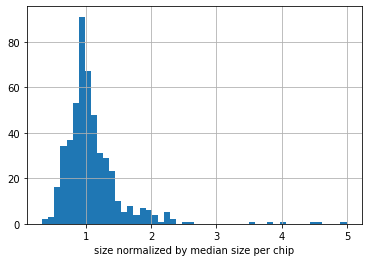

In [159]:
data.normd_size.hist(bins=50)
plt.xlabel('size normalized by median size per chip')

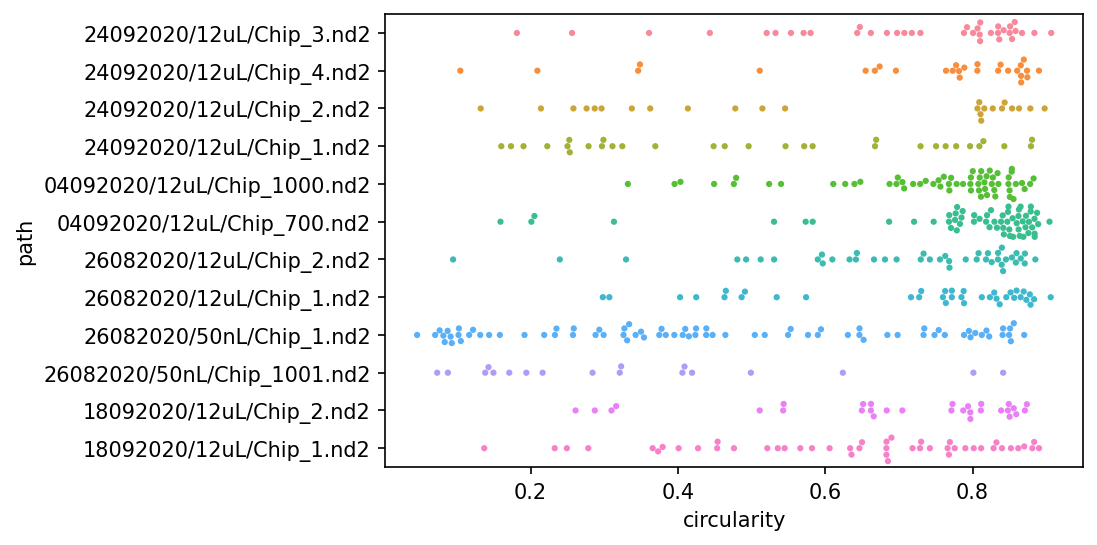

In [138]:
fig, ax = plt.subplots(dpi=150)
sns.swarmplot(y='path', x='circularity', data=data, size=3)

Text(0.5, 0, 'size normalized by median size per chip')

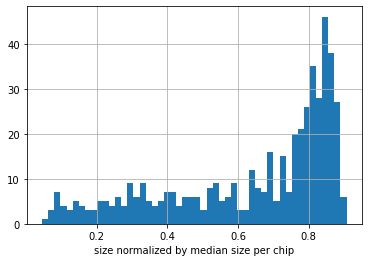

In [160]:
data.circularity.hist(bins=50)
plt.xlabel('size normalized by median size per chip')

In [163]:
data.to_csv('/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/To_analyze/results.csv')